In [1]:
import pandas as pd
import numpy as np
from benchmarks import MinVarianceMethod, MaxSharpeMethod
from environment import Environment
from utils import get_stats, cumulative_pct_change
from price_predictors import ArimaModel
from model_lstm import main as LstmModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Loading Environments

In [2]:
env = Environment()
minvar_method = MinVarianceMethod(allow_short=True)
maxsharpe_method = MaxSharpeMethod(allow_short=True)
arima_model = ArimaModel(allow_short=True)

# Testing and getting results

In [ ]:
WINDOW_FIT = 1300
WINDOW_HOLD = 400
N_ASSETS = len(env.returns.columns)
weights_equal, weights_minvar, weights_maxsharpe, weights_lstm = [], [], [], []
result_equal, result_minvar, result_maxsharpe, result_lstm = [], [], [], []


for i in range(WINDOW_FIT, len(env.returns), WINDOW_HOLD):
    print(f"Testing Window from {i-WINDOW_FIT} to {i} and Training window from {i} to {i+WINDOW_HOLD}")

    testing_period_returns = env.get_state(
        end=i, 
        lookback=WINDOW_FIT
        )
    
    holding_period_returns = env.get_state(
        end= i + WINDOW_HOLD, 
        lookback = WINDOW_HOLD
    )

    ################## BENCHMARK MODELS

    ### 1. Equal weights
    equal_weights = np.ones(N_ASSETS) / N_ASSETS

    r = np.dot(holding_period_returns, equal_weights)
    result_equal.append(r.tolist())
    weights_equal.append(equal_weights)

    ### 2. Min variance
    min_var_weights = minvar_method.get_optimal_weights(testing_period_returns)

    r = np.dot(holding_period_returns, min_var_weights)
    result_minvar.append(r.tolist())
    weights_minvar.append(min_var_weights)

    ### 3. Max Sharpe
    max_sharpe_weights = maxsharpe_method.get_optimal_weights(testing_period_returns)

    r = np.dot(holding_period_returns, max_sharpe_weights)
    result_maxsharpe.append(r.tolist())
    weights_maxsharpe.append(max_sharpe_weights)


    ################## Price Predictors put here: aka LSTM and RL
    prices = env.get_prices(
        end=i+WINDOW_HOLD, 
        lookback=WINDOW_FIT+WINDOW_HOLD
    )
    res, rmse_score, predicted_prices, actual_prices = LstmModel(filtered_data=prices, holding_period=WINDOW_HOLD)
    predicted_returns = predicted_prices.pct_change().dropna() * 100
    lstm_weights = maxsharpe_method.get_optimal_weights(predicted_returns)

    r = np.dot(holding_period_returns, lstm_weights)
    result_lstm.append(r.tolist())
    weights_lstm.append(lstm_weights)

# Evaluation

In [18]:
test = [0, -50, 50, ]
assert cumulative_pct_change(test).tolist() == [0,-50.0,-25.0]

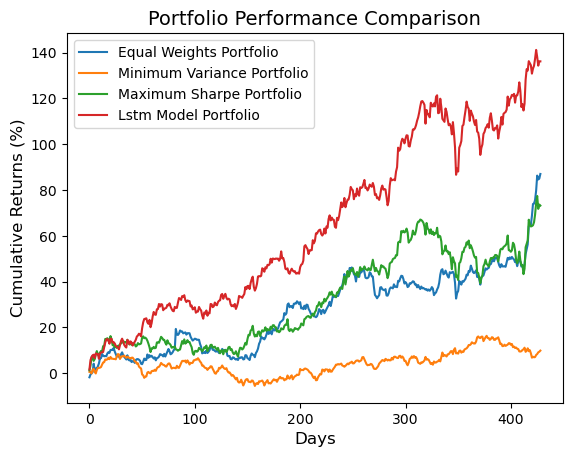

In [19]:
# flatten into list and compare results
equal_weights_daily_returns = [item for sublist in result_equal for item in sublist]
minvar_method_daily_returns = [item for sublist in result_minvar for item in sublist]
maxsharpe_method_daily_returns = [item for sublist in result_maxsharpe for item in sublist]
lstm_method_daily_returns = [item for sublist in result_lstm for item in sublist]

plt.figure()
plt.xlabel("Days", fontsize=12)
plt.ylabel("Returns (%)")
plt.plot(cumulative_pct_change(equal_weights_daily_returns), label = "Equal Weights Portfolio")
plt.plot(cumulative_pct_change(minvar_method_daily_returns), label = "Minimum Variance Portfolio")
plt.plot(cumulative_pct_change(maxsharpe_method_daily_returns), label = "Maximum Sharpe Portfolio")
plt.plot(cumulative_pct_change(lstm_method_daily_returns), label = "Lstm Model Portfolio")
plt.ylabel("Cumulative Returns (%)", fontsize=12)
plt.title("Portfolio Performance Comparison", fontsize=14)
plt.legend(fontsize=10)
plt.show()


In [20]:
results = []


equal_weights_stats = get_stats(equal_weights_daily_returns)
equal_weights_stats["Name"] = "Equal Weights Portfolio"
results.append(equal_weights_stats)

minvar_method_stats = get_stats(minvar_method_daily_returns)
minvar_method_stats["Name"] = "Minimum Variance Portfolio"
results.append(minvar_method_stats)

maxsharpe_method_stats = get_stats(maxsharpe_method_daily_returns)
maxsharpe_method_stats["Name"] = "Maximum Sharpe Portfolio"
results.append(maxsharpe_method_stats)

lstm_model_stats = get_stats(lstm_method_daily_returns)
lstm_model_stats["Name"] = "Lstm Model Portfolio"
results.append(lstm_model_stats)


stats = pd.DataFrame(results).set_index("Name")
stats

,Cumulative Return,Sharpe Ratio,Maximum Drawdown,Value at Risk
Name,,,,
Equal Weights Portfolio,87.002620,0.132844,0.648121,1.444204
Minimum Variance Portfolio,9.898188,0.033291,1.641540,1.207230
Maximum Sharpe Portfolio,73.187475,0.104150,0.491887,1.836808
Lstm Model Portfolio,136.158590,0.152152,0.286473,1.914030
